In [ ]:
conda env export > environment.yml

In [1]:
import os
import re
import string
import unicodedata
import pandas as pd 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

In [2]:
import inflect
from spellchecker import SpellChecker
import csv

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## import datasets

In [289]:
# import dataset
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
#target = pd.read_csv('train.csv', usecols=['target'])

In [290]:
print(len(df))
print(len(test_df))

7613
3263


In [292]:
test_df.drop(['id'], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)

In [294]:
#dups = df[df.duplicated(['text'])]
df.drop_duplicates(subset=['text'], keep='first', inplace=True)
test_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

print(len(df))
print(len(test_df))

7503
3243


## visualize target data

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

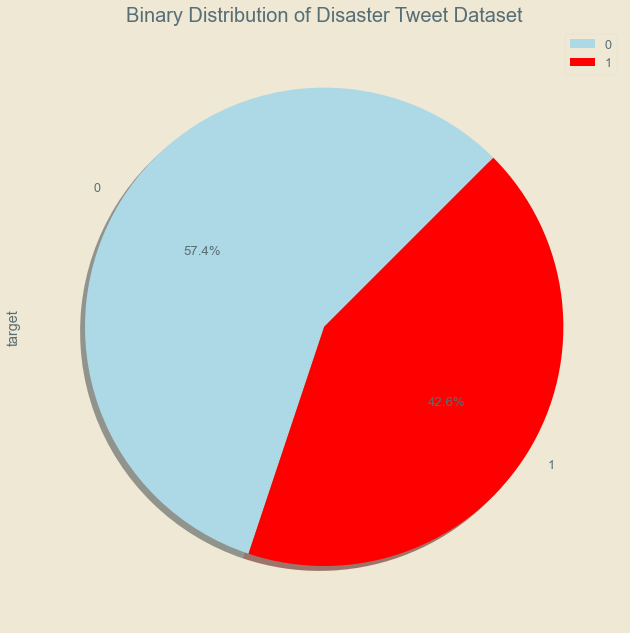

In [7]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
df.target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

# clean and process text

In [ ]:
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources
from tqdm import tqdm



## hashtags

In [ ]:
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
                    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
# Set max_dictionary_edit_distance to avoid spelling correction
result = sym_spell.word_segmentation(text)


In [953]:
def desegment_hashtag(text):
    spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename("symspellpy","frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    result = spell.word_segmentation(text)
    text = result.corrected_string
    return text
desegment_hashtag('#thisismyexampleofwordsegmentation')

'# this is my example of word segmentation'

In [961]:
import pkg_resources
from symspellpy import SymSpell

def desegment_hashtag(text):
    # Set max_dictionary_edit_distance to avoid spelling correction
    sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
                        "symspellpy", "frequency_dictionary_en_82_765.txt")
    # term_index is the column of the term and count_index is the
    # column of the term frequency
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    # Set max_dictionary_edit_distance to avoid spelling correction
    result = sym_spell.word_segmentation(text)
    text = result.corrected_string
    return text



import pkg_resources
from symspellpy import SymSpell, Verbosity

def spell_check_words(word):
    # lookup suggestions for individual words
    spell = SymSpell(max_dictionary_edit_distance=4, prefix_length=8)
    dictionary_path = pkg_resources.resource_filename(
                     "symspellpy", "frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    suggestions = spell.lookup(word, Verbosity.CLOSEST)
    print(suggestions[0])

In [962]:
spell_check_words('huboijeponf')

IndexError: list index out of range

In [968]:
def spell_check_words(word):
    # lookup suggestions for individual words
    spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
                      "symspellpy", "frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    corrections = spell.lookup(word, Verbosity.CLOSEST)
    for correction in corrections:
        print(correction)

In [970]:
def spell_check_words(word):
    # lookup suggestions for individual words
    spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
                      "symspellpy", "frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    corrections = spell.lookup(word, Verbosity.TOP)
    for correction in corrections:
        print(correction)

In [971]:
spell_check_words('pickel')

picked, 1, 12114899


In [891]:
# functions related to expanded hashtags in text
def pascal_case_split(text):
    # expand hashtags formatted in pascal case, ex: #ThisIsPascal
    return re.sub(r'([A-Z])([?=a-z0-9+])', r' \1\2', text)

def camel_case_split(text):
    # expand hashtags formatted in pascal case, ex: #thisIsCamel
    return re.sub(r'([a-z0-9+])([?<=A-Z])', r'\1 \2', text)

def remove_hash(text):
    # remove hash symbol in front of hashtag text and remove non unicode chars
    return re.sub('#', '', text)


def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^a-zA-Z_, ]', '', text)

        
def expand_hashtags(text):
    # combine hashtag split functions for specific cases and remove hash
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    h_text = remove_hash(p_text)
    return remove_non_uni(h_text)



def monocase_mask(text):
    # returns boolean mask for monocase strings 
    if text.isupper() | text.islower() and text != 'nan':
        return True

    else:
        return False
    
def mono_check(text):
    # returns boolean mask for monocase strings 
    text.isupper() | text.islower() and text != 'nan'


In [853]:
# create column for extracted hashtags
df['hashtags'] = df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
test_df['hashtags'] = test_df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
df.hashtags = df.hashtags.astype(str)
test_df.hashtags = test_df.hashtags.astype(str)

In [854]:
expanded_hashtags = df.hashtags.apply(lambda x: (expand_hashtags(x)))
df['expanded_hashtags'] = expanded_hashtags.str.strip()

In [855]:
#df['expanded_hashtags'] = df.expanded_hashtags.astype(str)
mask = df.expanded_hashtags.apply(lambda x: monocase_mask(x))
df['mc_mask'] = mask

In [924]:
words

0                                            [earthquake]
3                                             [wildfires]
6                                      [flood,, disaster]
11                                             [flooding]
12      [raining,, flooding,, Florida,, Tampa, Bay,, T...
                              ...                        
7580                               [FX,, forex,, trading]
7588                                               [ISIS]
7595                                               [tnwx]
7596                  [NWS,, Thunderstorm,, AR,, NC,, OK]
7601                                      [breaking,, LA]
Name: expanded_hashtags, Length: 826, dtype: object

In [952]:
subset = df.loc[df['mc_mask']==True]
words = subset.expanded_hashtags.str.split(',')

test = [desegment_hashtag(x)  for x in words]

TypeError: normalize() argument 2 must be str, not list

In [916]:
desegment_hashtag('#THISISANUPPERCASEEXAMPLE')

'# This Is An Uppercase Example'

In [914]:
desegment_hashtag('#thisisalowercaseexample')

'# this is a lowercase example'

In [935]:
df[550:600]

,keyword,location,text,target,tweets,clean_keyword,clean_location,all_text,combined_tokens,tweet_tokens,hashtags,expanded_hashtags,mc_mask,ht_seg,ht
554,battle,NaN,#Tb #throwback ??\n\n??~ You want a battle? He...,0,tb throwback want battle war zj wgma iw,battle,,tb throwback want battle war zj wgma iw battle,"[tb, throwback, want, battle, war, zj, wgma, i...","[tb, throwback, want, battle, war, zj, wgma, iw]","['#Tb', '#throwback']","Tb, throwback",False,Tb,Tb
555,battle,"San Jose, CA",Kelby Tomlinson mild-mannered 2nd baseman for ...,0,kelby tomlinson mild mannered second baseman g...,battle,san jose ca,kelby tomlinson mild mannered second baseman g...,"[kelby, tomlinson, mild, mannered, second, bas...","[kelby, tomlinson, mild, mannered, second, bas...",['#SFGiants'],SF Giants,False,SF Giants,SF Giants
556,battle,USA,Black Eye 9: A space battle occurred at Star M...,1,black eye space battle occur star involve flee...,battle,usa,black eye space battle occur star involve flee...,"[black, eye, space, battle, occur, star, invol...","[black, eye, space, battle, occur, star, invol...",[],,False,nan,nan
557,battle,San Francisco,What really happened in the Taken King Story T...,0,really happen take king story trailer space ba...,battle,san francisco,really happen take king story trailer space ba...,"[really, happen, take, king, story, trailer, s...","[really, happen, take, king, story, trailer, s...",[],,False,nan,nan
558,battle,NaN,THESE AFTER BATTLE ANIMATIONS ARE SO FUCKING MUCH,0,battle animations fuck much,battle,,battle animations fuck much battle,"[battle, animations, fuck, much, battle]","[battle, animations, fuck, much]",[],,False,nan,nan
559,battle,"Dallas, TX",See what happens with NO Battle of the Block @...,0,see happen battle block big brother finally,battle,dallas tx,see happen battle block big brother finally d...,"[see, happen, battle, block, big, brother, fin...","[see, happen, battle, block, big, brother, fin...",[],,False,nan,nan
560,battle,"Baton Rouge, LA",#DU19 who gon get in this rap battle with me,0,gon get rap battle,battle,baton rouge la,gon get rap battle baton rouge la battle,"[gon, get, rap, battle, baton, rouge, la, battle]","[gon, get, rap, battle]",['#DU19'],D U,True,D U19,D U19
561,battle,Use #TMW in tweets get #RT,Do Your Own Thing: The Battle of Internal vs E...,0,thing battle internal vs external motivation a...,battle,use tmw tweet get rt,thing battle internal vs external motivation a...,"[thing, battle, internal, vs, external, motiva...","[thing, battle, internal, vs, external, motiva...",[],,False,nan,nan
562,battle,Earth,Check out this item I just got! [Phantasmal Cu...,0,check item get phantasmal cummerbund hje rq wa...,battle,earth,check item get phantasmal cummerbund hje rq wa...,"[check, item, get, phantasmal, cummerbund, hje...","[check, item, get, phantasmal, cummerbund, hje...",['#Warcraft'],Warcraft,False,Warcraft,Warcraft
563,battle,NaN,A young German stormtrooper engaged in the Bat...,1,young german stormtrooper engage battle somme ...,battle,,young german stormtrooper engage battle somme ...,"[young, german, stormtrooper, engage, battle, ...","[young, german, stormtrooper, engage, battle, ...",[],,False,nan,nan


In [948]:
for index, row in df.iterrows():
    if str(row['mc_mask']) == 'True':
        row['expanded_hashtags'] = [hashtag_segmentation(x)



TypeError: normalize() argument 2 must be str, not list

In [949]:
for index,row in df.iterrows():
    df.loc[index,'repl'] = hashtag_segmentation(row['expanded_hashtags'])


IndexError: list index out of range

## dictionary based word replacement 

In [295]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}
location_expansion_dict = csv2dict('location_expansion.csv')

In [296]:
location_expansion_dict = csv2dict('location_expansion.csv')
contractions_dict = csv2dict('contractions.csv')

In [429]:
def word_expansion_from_dict(text, expansion_dict):
    c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion =  f"{expansion_dict[match.group(0)]}"
        return expansion
    text = c_re.sub(replace, text)
    return text

def pascal_case_split(text):
    #if text[0]=="#" and text[1].isupper():
        #text = re.sub('#', '', text)
    exp_ht = re.sub(r'([A-Z])([?=a-z0-9+])', r' \1\2', text)
   # else:
   #     exp_ht = text
    return exp_ht  

def camel_case_split(text):
    #if text[0]=="#" and text[1].islower():
        #text = re.sub('#', '', text)
    exp_ht = re.sub(r'([a-z0-9+])([?<=A-Z])', r'\1 \2', text)
   # else:
    #    exp_ht = text
    return exp_ht

def remove_hash(text):
    new_text = re.sub('#', '', text)
    return new_text
        
def expand_hashtags(text):
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    new_text = remove_hash(p_text)
    return new_text

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(rf'([({ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_vowels_mixed_case(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    uvowels = map(lambda x:x.upper(), [x for x in vowels])
    uv = list(uvowels)
    for ch in iter(vowels):
        text = re.sub(rf'([({ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    for ch in iter(uv):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants_mixed_case(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    uconsonants = map(lambda x:x.upper(), [x for x in consonants])
    uc = list(uconsonants)
    for ch in iter(consonants):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    for ch in iter(uc):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def remove_urls(text):
    # function to remove urls from string
    return re.sub(r"\S*https?:\S*",  r"", text)

def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@[^\s]+",  r" ", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z_]",  r" ", text)
    


## tokenize 

In [430]:
def lemmatize_text(text):
    #function to tokenize and lemmatize text, removing twitter handles and reducing length of words ex. loool = lol
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w, 'v') for w in text.split(' ')]
    return tokens


def replace_numbers(tokens):
    # function to replace digits in string with numbers spelled out as words ex 11 = eleven
    dig2word = inflect.engine()
    new_tokens = []
    for word in tokens:
        word = re.sub('(?<=\d),(?=\d)', ' ', word)
        if word.isdigit():
            new_word = dig2word.number_to_words(int(word))
            new_tokens.append(str(new_word))
        else:
            new_tokens.append(word)
    return new_tokens


def remove_non_ascii(tokens):
    # function to remove non unicode characters from tokenized text
    new_tokens = []
    for word in tokens:
        new_token = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_tokens.append(new_token)
    return new_tokens

def remove_stopwords(tokens):
    # function to remove stopwords from text
    stop_list = stopwords.words('english')  
    new_tokens = []
    for word in tokens:
        if word not in stop_list:
            new_tokens.append(word)
    return new_tokens

def norm_text(tokens):
    # function to normalize text by replacing digits with words and removing stopwords performed on tokenized text
    words = replace_numbers(tokens)
    new_words = remove_stopwords(words)
    return new_words

## tweet text process

In [431]:
#### text preprocessing specifically formatted for tweets but will work on any text
def process_tweet(df): 
    """combine regex and nltk processing for tweet text and keyword text processing"""
    def expand_text(text):
        text = expand_hashtags(text)
        text = word_expansion_from_dict(text, expansion_dict=location_expansion_dict)
        text = word_expansion_from_dict(text.lower(), expansion_dict=contractions_dict)
        return text
    

    def denoise_text(text):
        text = remove_urls(text)
        text = re.sub(r'(?<=\d)(?=[^\d\s])|(?<=[^\d\s])(?=\d)', ' ', text)
        text = remove_handles(text)
        text = reduce_repeat_vowels(text)
        text = reduce_repeat_consonants(text)
        text = remove_non_alpha(text)
        return text      

    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text)
        text = ' '.join(x for x in norm_text(lem_text) if len(x) > 1)
        return text

    
    new_df = [process_text(x) for x in df]

    return new_df 

## keyword text process

In [432]:
def process_keyword(df):
    text = df.str.replace('%20', ' ')
    return text

## location text process

In [433]:
def process_location(df):
    """combine regex and nltk processing for location text processing"""
    
    def expand_text(text):
        camel_text = expand_hashtags(text) 
        #loc_dict_lower = {k.lower(): v for k, v in location_expansion_dict.items()}
        exp_text = word_expansion_from_dict(camel_text, location_expansion_dict)
        return exp_text
        
    def process_text(text):
        exp_text = expand_hashtags(text)
        clean_text = denoise_text(exp_text)
        lem_text = lemmatize_text(clean_text)
        text = ' '.join([x for x in norm_text(lem_text)])
        return text
    
    new_df = [process_text(x) for x in df]
    return new_df 

## create column containing combined column text & tokens columns

In [434]:
def combine_columns(df):
    df['clean_keyword'] = df.clean_keyword.astype(str)
    df['clean_keyword'] = df.clean_keyword.str.lower()
    df['clean_keyword'] = df.clean_keyword.str.replace(r'nan', r'')
    df['clean_location'] = df.clean_location.astype(str)
    df['clean_location'] = df.clean_location.str.lower()
    df['clean_location'] = df.clean_location.str.replace(r'nan', r'')
    df['tweets'] = df.tweets.astype(str)
    df['all_text'] = df['tweets'].str.cat(df['clean_location'],sep=" ")
    df['all_text'] = df['all_text'].str.cat(df['clean_keyword'],sep=" ")
    df['all_text'] = df['all_text'].str.strip()
    df['combined_tokens'] = df.all_text.str.lower()
    df['tweet_tokens'] = df.tweets.str.lower()
    df['combined_tokens'] = df.combined_tokens.apply(lambda row: row.split())
    df['tweet_tokens'] = df.tweet_tokens.apply(lambda row: row.split())
    new_df = df.drop(['keyword', 'location', 'text'], axis=1)
    return new_df

# create new dataframe applying above processes

In [435]:
df['tweets'] = process_tweet(df.text)
test_df['tweets'] = process_tweet(test_df.text)
df['clean_keyword'] = process_keyword(df.keyword.astype(str))
test_df['clean_keyword'] = process_keyword(test_df.keyword.astype(str))
df['clean_location'] = process_location(df.location.astype(str))
test_df['clean_location'] = process_location(test_df.location.astype(str))

train_df = combine_columns(df)
test_df2 = combine_columns(test_df)

In [437]:
train_df.drop_duplicates(subset=['tweets'], keep='first', inplace=True)
print('train samples: ',len(train_df))
test_df2.drop_duplicates(subset=['tweets'], keep='first', inplace=True)
print('test samples: ',len(test_df2))

train samples:  7450
test samples:  3232


In [438]:
test_df2.to_csv('test_update_nosw.csv')
train_df.to_csv('train_update_nosw.csv')

In [439]:
from collections import Counter
word_dict = Counter(train_df.tweet_tokens.sum())
word_dict

Counter({'deeds': 2,
         'reason': 31,
         'earthquake': 45,
         'may': 88,
         'allah': 7,
         'forgive': 6,
         'us': 178,
         'forest': 66,
         'fire': 368,
         'near': 56,
         'la': 25,
         'ronge': 1,
         'sask': 1,
         'canada': 15,
         'residents': 8,
         'ask': 32,
         'shelter': 7,
         'place': 34,
         'notify': 1,
         'officer': 38,
         'evacuation': 46,
         'order': 40,
         'expect': 33,
         'people': 198,
         'receive': 4,
         'wildfires': 12,
         'california': 138,
         'get': 431,
         'send': 52,
         'photo': 44,
         'ruby': 2,
         'alaska': 14,
         'smoke': 54,
         'pour': 4,
         'school': 69,
         'rocky': 14,
         'update': 55,
         'hwy': 10,
         'close': 38,
         'directions': 1,
         'due': 30,
         'lake': 16,
         'county': 40,
         'afire': 1,
         'flood':

In [440]:
len(word_dict)

16394

In [ ]:
print(min(word_dict)[:100])

In [383]:
test_df[test_df['text'].str.contains("#")]

,keyword,location,text,tweets,clean_keyword,clean_location,all_text,combined_tokens,tweet_tokens
1,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different cities stay safe eve...,,,hear earthquake different cities stay safe eve...,"[hear, earthquake, different, cities, stay, sa...","[hear, earthquake, different, cities, stay, sa..."
3,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfires,,,apocalypse light spokane wildfires,"[apocalypse, light, spokane, wildfires]","[apocalypse, light, spokane, wildfires]"
17,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,previously doyin tv toke makinwa marriage cris...,ablaze,nigeria,previously doyin tv toke makinwa marriage cris...,"[previously, doyin, tv, toke, makinwa, marriag...","[previously, doyin, tv, toke, makinwa, marriag..."
18,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,check nsfw,ablaze,live on webcam,check nsfw live on webcam ablaze,"[check, nsfw, live, on, webcam, ablaze]","[check, nsfw]"
26,ablaze,NaN,#nowplaying Alfons - Ablaze 2015 on Puls Radio...,nowplaying alfons ablaze puls radio pulsradio ...,ablaze,,nowplaying alfons ablaze puls radio pulsradio ...,"[nowplaying, alfons, ablaze, puls, radio, puls...","[nowplaying, alfons, ablaze, puls, radio, puls..."
...,...,...,...,...,...,...,...,...,...
3237,wreckage,Canada,TOP STORY: wreckage from #MH370 officially con...,top story wreckage mh officially confirm repor...,wreckage,canada,top story wreckage mh officially confirm repor...,"[top, story, wreckage, mh, officially, confirm...","[top, story, wreckage, mh, officially, confirm..."
3240,wreckage,our galaxy,RT @australian Debris found on an Indian Ocean...,rt debris find indian ocean island confirm fli...,wreckage,galaxy,rt debris find indian ocean island confirm fli...,"[rt, debris, find, indian, ocean, island, conf...","[rt, debris, find, indian, ocean, island, conf..."
3252,NaN,NaN,#Ebola #EbolaOutbreak Ebola Virus: Birmingham ...,ebola ebola outbreak ebola virus birmingham al...,,,ebola ebola outbreak ebola virus birmingham al...,"[ebola, ebola, outbreak, ebola, virus, birming...","[ebola, ebola, outbreak, ebola, virus, birming..."
3257,NaN,NaN,The death toll in a #IS-suicide car bombing on...,death toll suicide car bomb ypg position villa...,,,death toll suicide car bomb ypg position villa...,"[death, toll, suicide, car, bomb, ypg, positio...","[death, toll, suicide, car, bomb, ypg, positio..."


In [489]:
train_df[train_df['tweets'].str.contains("cantwaittoplayinminneapolis")]


,target,tweets,clean_keyword,clean_location,all_text,combined_tokens,tweet_tokens
7288,0,whirlwind weekend start hours cantwaittoplayin...,whirlwind,,whirlwind weekend start hours cantwaittoplayin...,"[whirlwind, weekend, start, hours, cantwaittop...","[whirlwind, weekend, start, hours, cantwaittop..."


In [694]:
df.text.loc[df['tweets'].str.contains("cantwaittoplayinminneapolis")]

7288    Whirlwind weekend #1 starts in 12 hours #cantw...
Name: text, dtype: object